In [1]:
from pyomo.environ import *
import numpy as np
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

### Model Control ###

In [ ]:
# ==================================================================================================
#   Model Control
# ==================================================================================================
# Actual solar radiation data (New York in summer) for 24 hours
latitude = 42.444
longitude = -76.453

# Find the time zone
# tf = TimezoneFinder()
# tz = tf.timezone_at(lng=longitude, lat=latitude)
tz = "Etc/GMT+4"  # "Etc/GMT+4"

# Define the start and end datetime
start_time = pd.to_datetime({"year": [2024], "month": [5], "day": [1], "hour": [0], "minute": [0]})[0].tz_localize(tz)
end_time = pd.to_datetime({"year": [2024], "month": [8], "day": [31], "hour": [23], "minute": [59]})[0].tz_localize(tz)

# Criteria
criteria_plant = "dli"

# DLI target [mol m⁻² d⁻¹]
DLI_target = 40.0

# Biomass requirement ratio
biomass_requirement_ratio = 0.6

# Dynamic tracking angles
# options = ["dynamic", "binary_select", "standard_tracking", "antitracking", "fixed_schedule"]
tracking_strategy = "dynamic"

tracking_start_hour = 10
tracking_end_hour = 15


### Inputs ###

In [43]:
# ==================================================================================================
#   PV Design
# ==================================================================================================
# The width of the solar panel row/array
# [The edge that rotates about its midpoint with a changing tilt]
width_p = 2
# The length of the solar panel row/array
length_p = 20
# The height of the surface at its centerline
height_p = 2
# Site azimuth [north-south rows: 0 deg; east-west rows: 90 deg]
site_azimuth = 0
# Interrow spacing: the distance between the center of the panels of nearby rows
interrow_spacing_p = 6
# Intrarow spacing: the distance between the center of the nearby panels in one row
intrarow_spacing = 0
# row number: Number of rows defined in inputs
row_number = 14
# Panel number in a row
surf_number = 1
# Domain border length: The distance from the edge of the horizontal panels to the domain boundary
border_do = 2
# Maximum tracking angle
max_angle = 60
# Maximum change in tilt angle in one time step
delta_theta = None
# Backtracking
backtrack = True
# Bifacial panels
bifacial = True

# ==================================================================================================
#   Weather
# ==================================================================================================
# PAR to total spectrum ratio [generally 0.45 - 0.53]
ratio_PAR = 0.5
# PAR photon energy [umol J⁻¹]
qc_PAR = 4.6
# It is likely that this is not a fixed constant;
# for example, it may vary over the season, so maybe adding an array of this value may be helpful.

# Surface albedo
albedo = 0.2
# Diffuse fraction coefficients for the diffuse fraction model
# [-0.05287, 0.1420, 0.5012] for row spacing 4 m
df_coeff = [-0.01871471, 0.05827023, 0.6669363]

# ==================================================================================================
#   Plant Growth
# ==================================================================================================
# Radiation Use Efficiency [g MJ⁻¹ m⁻²]
rue = 1.3
# Base temperature for plant growth [C]
base_temp_plant = 4
# Optimal temperature for plant growth [C]
optimal_temp_plant = 22
# Maximum temperature for plant growth [C]
max_temp_plant = 34.0
# Extreme temperature for plant growth [C]
extreme_temp_plant = 45.0
# Water stress factor
s_water = 0.4
# Canopy senescence factors
s_senescence_heat = 50
s_senescence_water = 30
# Cumulative temperature requirement for plant growth [C d]
temp_sum_plant = 2400
# Harvest index
harvest_index = 0.45
# Cumulative temperature requirement for leaf area development [C d]
temp_sum_leaf_area_development = 690
# Cumulative temperature requirement till maturity for canopy senescence [C d]
temp_sum_senescence = 450
# Canopy coverage maximum
f_solar_max = 0.95
# Canopy coverage initial
f_solar_initial = 0.001
# Initial biomass [kg ha⁻¹]
initial_biomass = 1.0

# ==================================================================================================
#   Power Generation
# ==================================================================================================
# Power price
# power_price = [50] * time_steps # $/MWh
# Number of modules does not matter for this calculation unless including the size of site
# Nameplate DC rating per module [generation at 1000 W/m2]
pdc0 = 5000000 # 5 MW
# Temperature coefficient [1/C]
gamma_pdc = -0.003
# Reference temperature [C]
temperature_ref = 25
# pvsyst temperature model
wind_speed_default = 1.0
u_c = 29.0
u_v = 0.0
module_efficiency = 0.1
alpha_absorption = 0.9
# Bifaciality factor: the ratio of the rear side to the front side of the module
bifaciality_factor = 0.8

In [44]:
# ==================================================================================================
#   Input Data
# ==================================================================================================
# --------------------------------------------------------------------------------------------------
# Read weather [Under ./data/weather/hourly_weather/]
# --------------------------------------------------------------------------------------------------
# Weather file name
hourly_weather = "CUEE2401"

# Load the weather data (assuming the file is a CSV; if it"s an Excel file, use pd.read_excel instead)
weather_data = pd.read_csv(f"../../adapt/data/weather/hourly_weather/CUEE2401.csv", skiprows=6)

# Combine Year, Month, Day, Hour, and Minute into a single datetime column
# Add 30 minutes to simulate the mid of the hour [can be removed]
weather_data["datetime"] = pd.to_datetime(weather_data[["year", "month", "day", "hour"]])
weather_data = weather_data.loc[:, ~weather_data.columns.str.contains("^Unnamed")]

# Filter the weather data for the specified date range
weather_data = weather_data.set_index("datetime")
weather_data.index = weather_data.index.tz_localize(tz)

# Extract the data from the start to the end time
weather_data = weather_data[(weather_data.index >= start_time) & (weather_data.index <= end_time)]
hourly_timesteps = weather_data.index

# Create a pvlib location object
site_location = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=tz)

# Calculate solar angles
solar_angles = site_location.get_solarposition(hourly_timesteps)

theta_e = solar_angles["apparent_elevation"].values
phi_a = solar_angles["azimuth"].values
DNI = weather_data["dni"].values
DHI = weather_data["dhi"].values
GHI = weather_data["ghi"].values
air_temp = weather_data["temperature"].values

# Ensure theta_e is non-negative
theta_e[GHI > 0] = np.maximum(theta_e[GHI > 0], 5.0)
theta_e[GHI == 0] = 1e-6

# Relative azimuth angle
phi_r = phi_a - site_azimuth

# Convert to radians
phi_r = np.deg2rad(phi_r)
theta_e = np.deg2rad(theta_e)

# Reference GHI and DLI
ghi_ref = np.mean(GHI)
dhi_ref = np.mean(DHI)
dli_ref = ghi_ref * ratio_PAR * qc_PAR * 24 * 3600 / 1e6
dli_max = (ghi_ref - dhi_ref * width_p / interrow_spacing_p) * ratio_PAR * qc_PAR * 24 * 3600 / 1e6

print(f"Reference GHI: {ghi_ref:.2f} W/m²")
print(f"Reference DHI: {dhi_ref:.2f} W/m²")
print(f"Reference DLI: {dli_ref:.2f} mol/m²/day")
print(f"Maximum DLI: {dli_max:.2f} mol/m²/day")

Reference GHI: 250.00 W/m²
Reference DHI: 100.54 W/m²
Reference DLI: 49.68 mol/m²/day
Maximum DLI: 43.02 mol/m²/day


In [45]:
solar_angles.iloc[:24, :]

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
datetime,,,,,,
2024-05-01 00:00:00-05:00,122.329609,122.329609,0.000001,-32.329609,359.179814,2.942240
2024-05-01 01:00:00-05:00,120.840707,120.840707,0.000001,-30.840707,16.095233,2.947079
2024-05-01 02:00:00-05:00,116.327101,116.327101,0.000001,-26.327101,31.770734,2.951902
2024-05-01 03:00:00-05:00,109.391688,109.391688,0.000001,-19.391688,45.570132,2.956709
2024-05-01 04:00:00-05:00,100.709642,100.709642,0.000001,-10.709642,57.571047,2.961499
2024-05-01 05:00:00-05:00,90.852326,90.852326,0.000001,-0.852326,68.229142,2.966274
2024-05-01 06:00:00-05:00,80.169341,80.258604,9.830659,9.741396,78.125759,2.971032
2024-05-01 07:00:00-05:00,69.233780,69.276333,20.766220,20.723667,87.904023,2.975773
2024-05-01 08:00:00-05:00,58.202604,58.228861,31.797396,31.771139,98.346972,2.980499


### Initialization ###

In [27]:
# ==================================================================================================
#   Parameter Initialization
# ==================================================================================================
# Length of one time step
time_interval = (hourly_timesteps[1] - hourly_timesteps[0]).total_seconds()  # sec
# Number of time steps in one run
time_steps = len(hourly_timesteps)

# Initial tracking angle
initial_theta = 0

# Trignometry
sin_phi_r = np.sin(phi_r)
cos_phi_r = np.cos(phi_r)
tan_theta_e = np.tan(theta_e)

sin_theta_e = np.sin(theta_e)
cos_theta_e = np.cos(theta_e)

# Diffuse fraction factor
a, b, c = df_coeff

# Solar elevation angle on the xz-plane
# [positive means positive x direction]
optimal_angle = np.arctan((cos_theta_e * sin_phi_r) / sin_theta_e)
# Always positive
theta_z_xz = np.arctan((cos_theta_e * np.abs(sin_phi_r)) / sin_theta_e)

# Ground cover ratio
gcr = width_p / interrow_spacing_p

# if wind_speed is None:
#     wind_speed = [wind_speed_default] * time_steps

# Constrain tilt angles to physical limits
max_tilt_rad = np.radians(max_angle)
constrained_angle_tracking = np.clip(optimal_angle, -max_tilt_rad, max_tilt_rad)
constrained_angle_antitracking = optimal_angle - np.sign(optimal_angle) * np.pi / 2
constrained_angle_antitracking = np.clip(constrained_angle_antitracking, -max_tilt_rad, max_tilt_rad)

# Shadow width (only when sun is up)
sun_up = np.heaviside(theta_e, 1)
panel_width_shadow_tracking = (
    (sin_phi_r / np.tan(theta_e) * np.sin(constrained_angle_tracking) +
     np.cos(constrained_angle_tracking)) * width_p * sun_up
)

# Initialize adjusted angles
angle_tracking = constrained_angle_tracking.copy()
angle_antitracking = constrained_angle_antitracking.copy()

# Backtracking adjustment
for t in range(len(theta_e)):
    # Adjust tracking angle
    if panel_width_shadow_tracking[t] > interrow_spacing_p:
        pass
        dtheta = np.arccos(interrow_spacing_p / width_p * np.cos(theta_z_xz[t]))
        angle_tracking[t] = optimal_angle[t] - dtheta if optimal_angle[t] >= 0 else optimal_angle[t] + dtheta

# Zero tilt when sun is down
angle_tracking *= sun_up
angle_antitracking *= sun_up

# ==================================================================================================
#   Plant Growth Parameters
# ==================================================================================================
n_days = int(time_steps / (86400 / time_interval))
steps_per_day = 86400 / time_interval

# Daily statistics for air temperature
daily_stats = weather_data.resample("1D").agg(["min", "max", "mean"])["temperature"]
daily_min_air_temp = daily_stats["min"].values
daily_max_air_temp = daily_stats["max"].values
daily_mean_air_temp = daily_stats["mean"].values

daily_stats = weather_data.resample("1D").agg(["mean"])["ghi"]
daily_srad = daily_stats["mean"].values * 86400 * 1e-6

# Thermal time calculation
d_thermal_time = np.maximum(daily_mean_air_temp - base_temp_plant, 0.0)
thermal_time = np.zeros(n_days + 1)
thermal_time[0] = 0.0
for d in range(1, n_days + 1):
    thermal_time[d] = thermal_time[d - 1] + d_thermal_time[d - 1]
    # Ensure thermal time does not exceed the cumulative temperature requirement
    if thermal_time[d] > temp_sum_plant:
        n_days = d
        break

# Temperature growth factor
temp_growth_factor = np.clip((daily_mean_air_temp - base_temp_plant) / (optimal_temp_plant - base_temp_plant), 0, 1)
heat_growth_factor = np.clip((extreme_temp_plant - daily_max_air_temp) / (extreme_temp_plant - max_temp_plant), 0, 1)

# Canopy growth factor
canopy_growth_factor = np.zeros(n_days + 1)
canopy_growth_factor[0] = f_solar_initial
canopy_growth_factor[1:] = np.minimum(
    f_solar_max / (1 + np.exp(-0.01 * (thermal_time[1:] - temp_sum_leaf_area_development))),
    f_solar_max / (1 + np.exp(0.01 * (thermal_time[1:] - temp_sum_plant + temp_sum_senescence)))
)

# Reference biomass
biomass_ref = initial_biomass + sum(
    10 * rue * daily_srad * canopy_growth_factor[:-1] * temp_growth_factor * heat_growth_factor
)
cumulative_biomass = np.zeros(n_days + 1)
cumulative_biomass[0] = initial_biomass
# Cumulative biomass calculation
for d in range(1, n_days + 1):
    cumulative_biomass[d] = cumulative_biomass[d - 1] + (
        10 * rue * daily_srad[d - 1] * canopy_growth_factor[d - 1] * temp_growth_factor[d - 1] * heat_growth_factor[d - 1]
    )

print(f"Reference biomass at harvest: {biomass_ref:.2f} kg ha⁻¹")

Reference biomass at harvest: 16331.02 kg ha⁻¹


In [28]:
# ==================================================================================================
#   Add deficit out of the loop
# ==================================================================================================
# # Input calculated DLI from the previous iterations
# DLI_model = None # model.DLI[t] for t in range(-time_steps,0,-1) # this must be the previously saved model output
# DLI_actual = actual_radiation * ratio_PAR * qc_PAR * 24 * 3600 / 1e6 # No conversion needed if already in PAR units

# deficit = sum(DLI_model) / time_steps - sum(DLI_actual) / time_steps
deficit = 0

### Run Optimization ###

In [29]:
# ==================================================================================================
#   Create Pyomo model
# ==================================================================================================
model = ConcreteModel()

# ==================================================================================================
#   Decision variable
# ==================================================================================================

if tracking_strategy == "dynamic":
    model.θ = Var(
        range(time_steps),
        bounds=(-np.radians(max_angle), np.radians(max_angle)),
        initialize=initial_theta
    )
elif tracking_strategy == "binary_select":
    model.st = Var(range(time_steps), bounds=(0, 1), initialize=1.0)
    # Var(range(time_steps), within=Binary)

    # angle_tracking and angle_antitracking should be Python lists or dicts
    model.θ = Expression(
        range(time_steps),
        rule=lambda m, t: angle_tracking[t] * m.st[t] + angle_antitracking[t] * (1 - m.st[t])
    )

    penalty_expr = sum(model.st[t] * (1 - model.st[t]) for t in range(time_steps))
    model.penalty = Expression(expr=penalty_expr)
    ε = 1e6

elif tracking_strategy == "standard_tracking":
    model.θ = Var(
        range(time_steps),
        bounds=(-np.radians(max_angle), np.radians(max_angle)),
        initialize=initial_theta
    )
    for t in range(time_steps):
        model.θ[t].fix(angle_tracking[t])
elif tracking_strategy == "antitracking":
    model.θ = Var(
        range(time_steps),
        bounds=(-np.radians(max_angle), np.radians(max_angle)),
        initialize=initial_theta
    )
    for t in range(time_steps):
        model.θ[t].fix(angle_antitracking[t])
elif tracking_strategy == "fixed_schedule":
    model.θ = Var(
        range(time_steps),
        bounds=(-np.radians(max_angle), np.radians(max_angle)),
        initialize=initial_theta
    )
    for t in range(time_steps):
        if hourly_timesteps[t].hour >= tracking_start_hour and hourly_timesteps[t].hour <= tracking_end_hour:
            model.θ[t].fix(angle_tracking[t])
        else:
            model.θ[t].fix(angle_antitracking[t])
else:
    raise ValueError(f"Unknown tracking strategy: {tracking_strategy}")

# ==================================================================================================
#   Constraint
# ==================================================================================================
# ----------------------------------------------------------------------------------------------------
#   Ground radiation
# ----------------------------------------------------------------------------------------------------
# Shadow length: Projected panel width on the ground
# Important: We are forcing the panels always to face the sunlight (+/- 90 deg from sun-tracking angles)
def panel_width_shadow_expr(model, t):
    # Shadow length [Option 2: Shadow projection]
    # return cos(model.θ[t] - optimal_angle[t]) * width_p / np.cos(theta_z_xz[t])
    # Shadow length [Option 1: Simiplified ART]
    return (sin_phi_r[t] / tan_theta_e[t] * sin(model.θ[t]) + cos(model.θ[t])) * width_p
model.panel_width_shadow = Expression(range(time_steps), rule=panel_width_shadow_expr)

# Shadow constraints
model.shadow_constraints = ConstraintList()
for t in range(time_steps):
    model.shadow_constraints.add(model.panel_width_shadow[t] >= 0.0)

if backtrack:
    for t in range(time_steps):
        model.shadow_constraints.add(model.panel_width_shadow[t] <= interrow_spacing_p)

# Diffuse fraction factor
def diffuse_fraction_expr(model, t):
    return a * model.θ[t] ** 4 + b * model.θ[t] ** 2 + c
model.diffuse_fraction = Expression(range(time_steps), rule=diffuse_fraction_expr)

# Ground radiation expression
def ground_radiation_expr(model, t):
    return (1 - model.panel_width_shadow[t] / interrow_spacing_p) * sin(theta_e[t]) * DNI[t] + DHI[t] * model.diffuse_fraction[t]
model.ground_radiation = Expression(range(time_steps), rule=ground_radiation_expr)

# Plant intercepted radiation [MJ/m²]
def ground_radiation_plant_expr(model, t):
    return  model.ground_radiation[t] * time_interval / 1e6
model.ground_radiation_plant = Expression(range(time_steps), rule=ground_radiation_plant_expr)

# --------------------------------------------------------------------------------------------------
#   Plant growth
# --------------------------------------------------------------------------------------------------
# model.cumulative_biomass = Var(range((time_steps)), initialize=0.0)

if criteria_plant == "biomass":
    # Daily radiation accumulation [MJ/m²/day]
    def daily_radiation_expr(model, d):
        start = round(d * steps_per_day)
        end = round((d + 1) * steps_per_day)
        duration = (end - start) * time_interval
        return sum(model.ground_radiation_plant[t] for t in range(start, end)) / (duration / 86400)

    model.daily_radiation = Expression(range(n_days), rule=daily_radiation_expr)

    # Cumulative biomass growth expression
    model.cumulative_biomass = Var(range(n_days + 1), initialize=0.0)
    model.cumulative_biomass_constraints = ConstraintList()
    model.cumulative_biomass_constraints.add(model.cumulative_biomass[0] == initial_biomass)
    for d in range(n_days):
        model.cumulative_biomass_constraints.add(
            model.cumulative_biomass[d + 1] == model.cumulative_biomass[d]
            + 10.0 * rue * model.daily_radiation[d]
            * canopy_growth_factor[d] * temp_growth_factor[d] * heat_growth_factor[d]
        )

    # Biomass constraint
    model.biomass_requirement = Constraint(
        expr=model.cumulative_biomass[n_days] >= biomass_ref * biomass_requirement_ratio
    )

elif criteria_plant == "dli":
    # DLI expression
    def DLI_expr(model, t):
        return  model.ground_radiation[t] * ratio_PAR * qc_PAR * 24 * 3600 / 1e6
    model.DLI = Expression(range(time_steps), rule=DLI_expr)

    # DLI constraint
    model.DLI_constraint = Constraint(expr=sum(model.DLI[t] for t in range(time_steps)) / time_steps >= DLI_target + deficit)

else:
    raise ValueError(f"Unknown plant growth criteria: {criteria_plant}")

# May add a temperature effect later

# --------------------------------------------------------------------------------------------------
#   Rate of change in tilt angle
# --------------------------------------------------------------------------------------------------
# Constraints for limiting rate of change of tilt angle
if delta_theta != None:
    model.angle_change_constraints = ConstraintList()
    for t in range(time_steps - 1):
        model.angle_change_constraints.add(model.θ[t + 1] - model.θ[t] <= delta_theta / 180 * np.pi)
        model.angle_change_constraints.add(model.θ[t + 1] - model.θ[t] >= - delta_theta / 180 * np.pi)

# ==================================================================================================
#   Objective: Power Generation
# ==================================================================================================
# AOI expression
def cos_aoi_expr(model, t):
    return cos(model.θ[t]) * sin(theta_e[t]) + sin(model.θ[t]) * cos(theta_e[t]) * sin(phi_r[t])

model.cos_aoi = Expression(range(time_steps), rule=cos_aoi_expr)

# Bloackage angle expression
def blockage_angle_large_expr(model, t):
    return atan(width_p / 2 * sin(model.θ[t]) / (interrow_spacing_p - width_p / 2 * cos(model.θ[t])))
    # return (width_p / 2 * sin(model.θ[t]) / (interrow_spacing_p - width_p / 2 * cos(model.θ[t]))) / (1 + 0.28 * (width_p / 2 * sin(model.θ[t]) / (interrow_spacing_p - width_p / 2 * cos(model.θ[t])))**2)
model.blockage_angle_large = Expression(range(time_steps), rule=blockage_angle_large_expr)

def blockage_angle_small_expr(model, t):
    return atan(width_p / 2 * sin(model.θ[t]) / (interrow_spacing_p + width_p / 2 * cos(model.θ[t])))
    # return (width_p / 2 * sin(model.θ[t]) / (interrow_spacing_p + width_p / 2 * cos(model.θ[t]))) / (1 + 0.28 * (width_p / 2 * sin(model.θ[t]) / (interrow_spacing_p + width_p / 2 * cos(model.θ[t])))**2)
model.blockage_angle_small = Expression(range(time_steps), rule=blockage_angle_small_expr)

# Front surface irradiance expression
def front_surface_irradiance_expr(model, t):
    return model.cos_aoi[t] * DNI[t] + DHI[t] * (cos(model.θ[t] + model.blockage_angle_large[t]) + 1) / 2 + albedo * model.ground_radiation[t] * (1 - cos(model.θ[t] - model.blockage_angle_small[t])) / 2
model.front_surface_irradiance = Expression(range(time_steps), rule=front_surface_irradiance_expr)

# Back surface irradiance expression
def back_surface_irradiance_expr(model, t):
    return DHI[t] * (1 - cos(model.θ[t] - model.blockage_angle_small[t])) / 2 + albedo * model.ground_radiation[t] * (cos(model.θ[t] + model.blockage_angle_large[t]) + 1) / 2
model.back_surface_irradiance = Expression(range(time_steps), rule=back_surface_irradiance_expr)

# Power generation expression
if bifacial:
    def incident_irradiance_expr(model, t):
        return model.front_surface_irradiance[t] + model.back_surface_irradiance[t] * bifaciality_factor
else:
    def incident_irradiance_expr(model, t):
        return model.front_surface_irradiance[t]
model.incident_irradiance = Expression(range(time_steps), rule=incident_irradiance_expr)

# model.temperature = Param(range(time_steps), initialize={t: temperature[t] for t in range(time_steps)}, mutable=True)
def cell_temp_expr(model, t):
    heat_input = (model.front_surface_irradiance[t] + model.back_surface_irradiance[t]) * alpha_absorption * (1 - module_efficiency)
    temp_difference = heat_input / (u_c + u_v * 0.0)  # wind_speed[t]
    return  temp_difference + air_temp[t]
model.cell_temp = Expression(range(time_steps), rule=cell_temp_expr)

def power_generation_expr(model, t):
    return  pdc0 * model.incident_irradiance[t] / 1000 * (1 + gamma_pdc * (model.cell_temp[t] - temperature_ref))
model.power_generation = Expression(range(time_steps), rule=power_generation_expr)

# Objective function: maximize power generation
# power_price not needed unless some panelties or DLI panalities apply
def objective_rule(model):
    if tracking_strategy == "binary_select":
        return sum(model.power_generation[t] for t in range(time_steps)) - ε * model.penalty
    else:
        return sum(model.power_generation[t] for t in range(time_steps))

model.objective = Objective(rule=objective_rule, sense=maximize)

# ==================================================================================================
#   Solution
# ==================================================================================================
# Solve the optimization problem using Ipopt
solver = SolverFactory("ipopt")  # executable="../../adapt/utilities/ipopt/bin/ipopt.exe"
# if tracking_strategy != "binary_select":
#     solver = SolverFactory("ipopt")  # executable="../../adapt/utilities/ipopt/bin/ipopt.exe"
# else:
#     solver = SolverFactory("bonmin", executable="../../adapt/utilities/optimization_solvers/bonmin.exe")  # set path
solver.solve(model, tee=True)

Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     7763
Number of nonzeros in Lagrangian Hessian.............:     2952

Total number of variables............................:     2952
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2952
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 5905, 'Number of variables': 2952, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.17\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 1.9338741302490234}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [30]:
np.mean(value(model.DLI[:]))

39.99999960000014

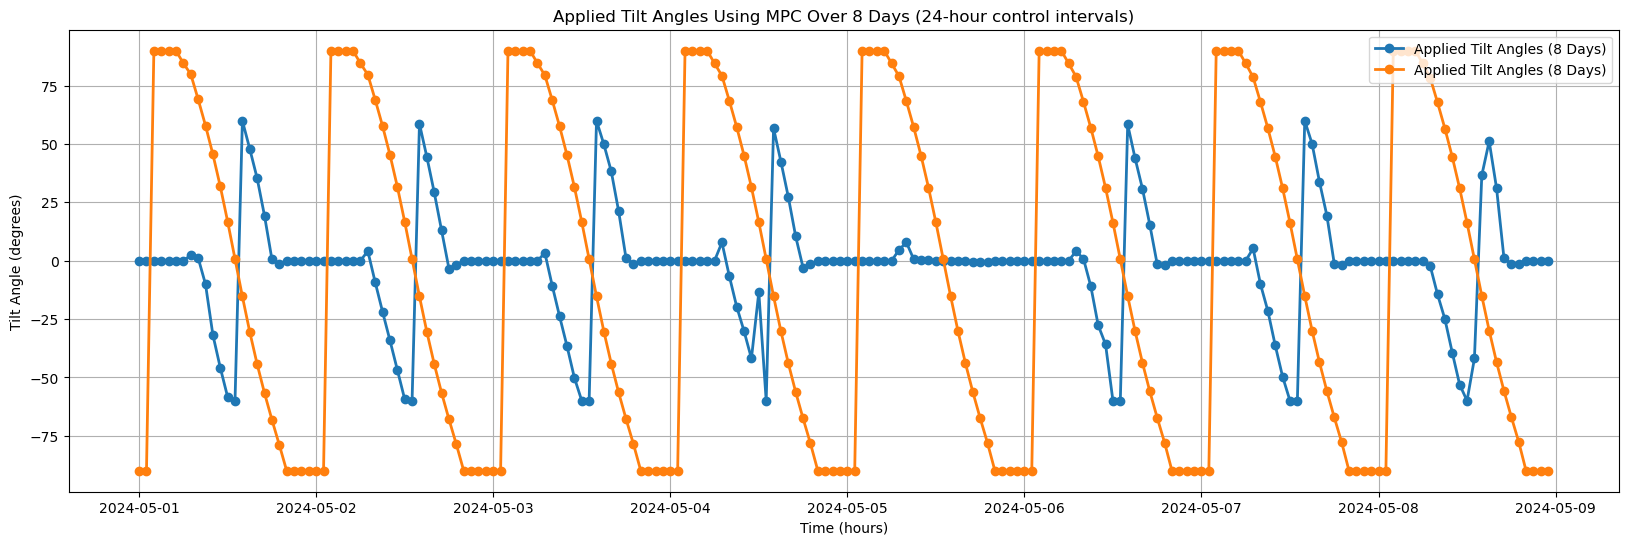

In [31]:
# Plot the applied tilt angles
plt.figure(figsize=(20, 6))
plt.plot(hourly_timesteps[:192], np.rad2deg(value(model.θ[:])[:192]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(hourly_timesteps[:192], np.rad2deg(optimal_angle[:192]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (hours)")
plt.ylabel("Tilt Angle (degrees)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()


### Results ###

In [11]:
panel_width_shadow = np.where(theta_e > 0, value(model.panel_width_shadow[:]), 0) # or None for nighttime
tracker_theta = np.where(theta_e > 0, value(model.θ[:]), 0)
cos_aoi = np.where(theta_e > 0, value(model.cos_aoi[:]), 0)
power_generation = np.where(theta_e > 0, value(model.power_generation[:]), 0)
objective = np.where(theta_e > 0, value(model.objective[:]), 0)

In [ ]:
np.mean(power_generation) / 1e6  # Convert to MW

1.2019524283887844

: 

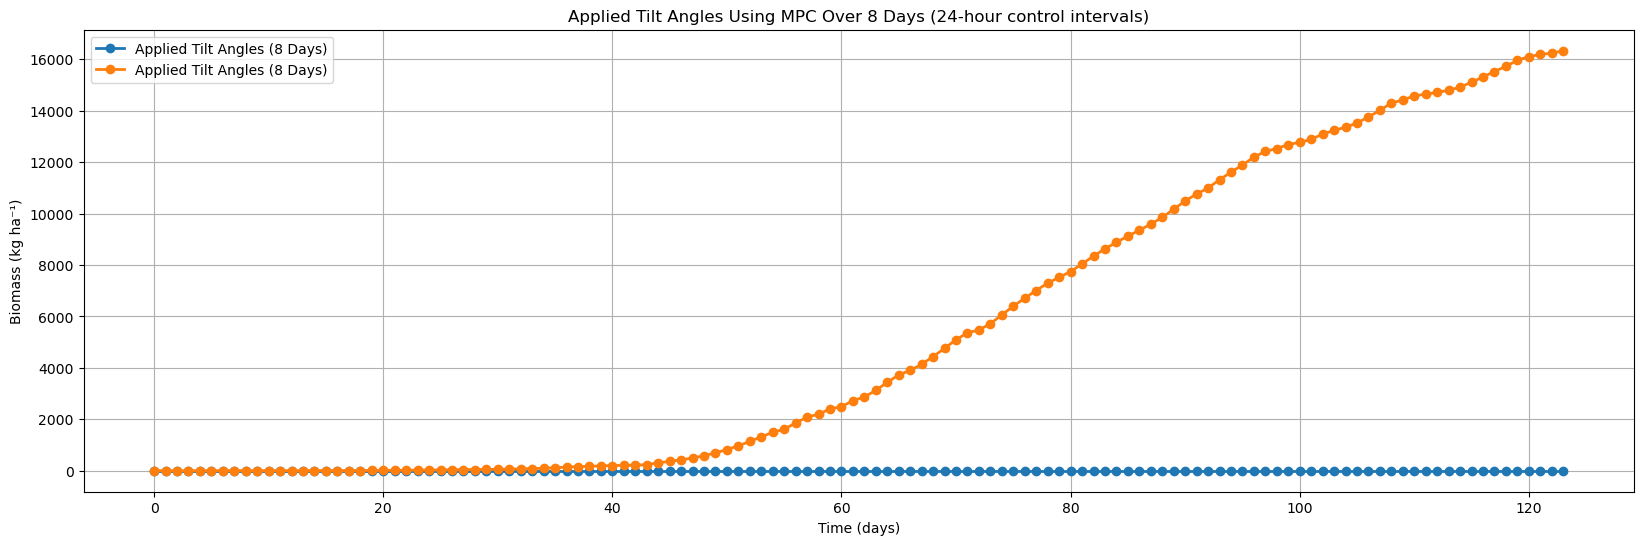

In [ ]:
# Plot the applied tilt angles
plt.figure(figsize=(20, 6))
plt.plot(range(len(value(model.cumulative_biomass[:]))), value(model.cumulative_biomass[:]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(range(len(cumulative_biomass)), cumulative_biomass, label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (days)")
plt.ylabel("Biomass (kg ha⁻¹)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()



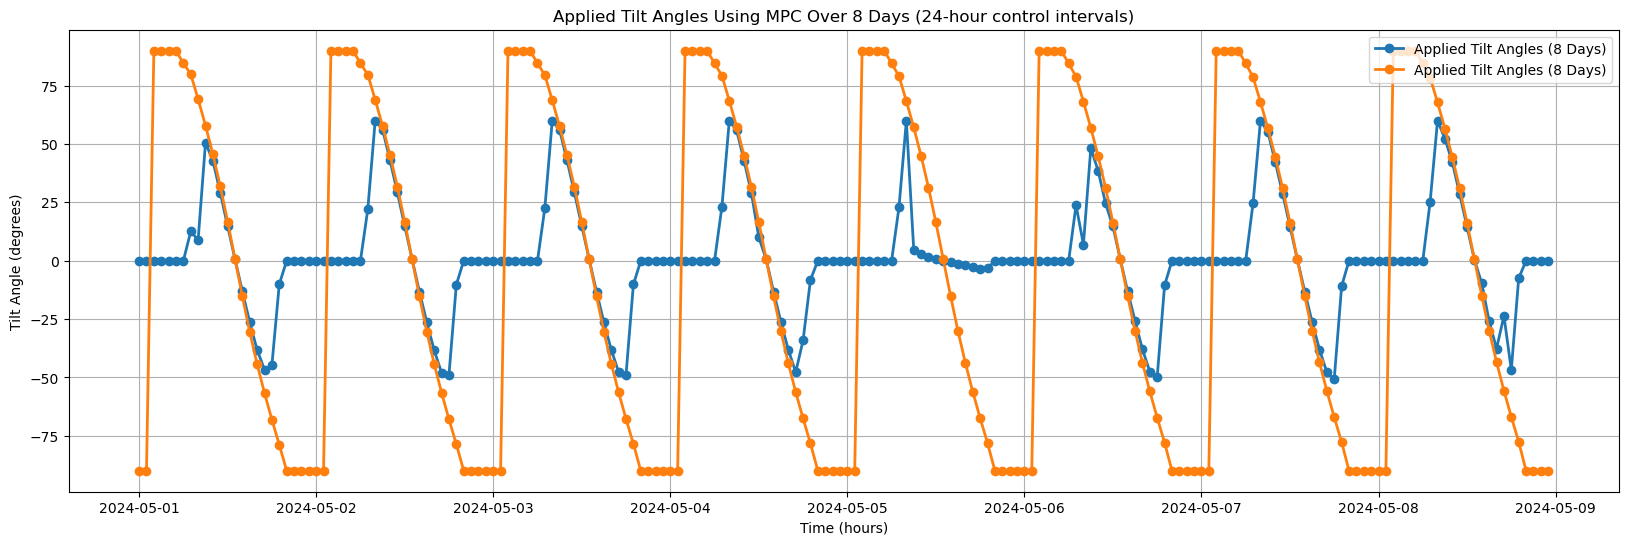

In [ ]:
# Plot the applied tilt angles
plt.figure(figsize=(20, 6))
plt.plot(hourly_timesteps[:192], np.rad2deg(value(model.θ[:])[:192]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(hourly_timesteps[:192], np.rad2deg(optimal_angle[:192]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (hours)")
plt.ylabel("Tilt Angle (degrees)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()


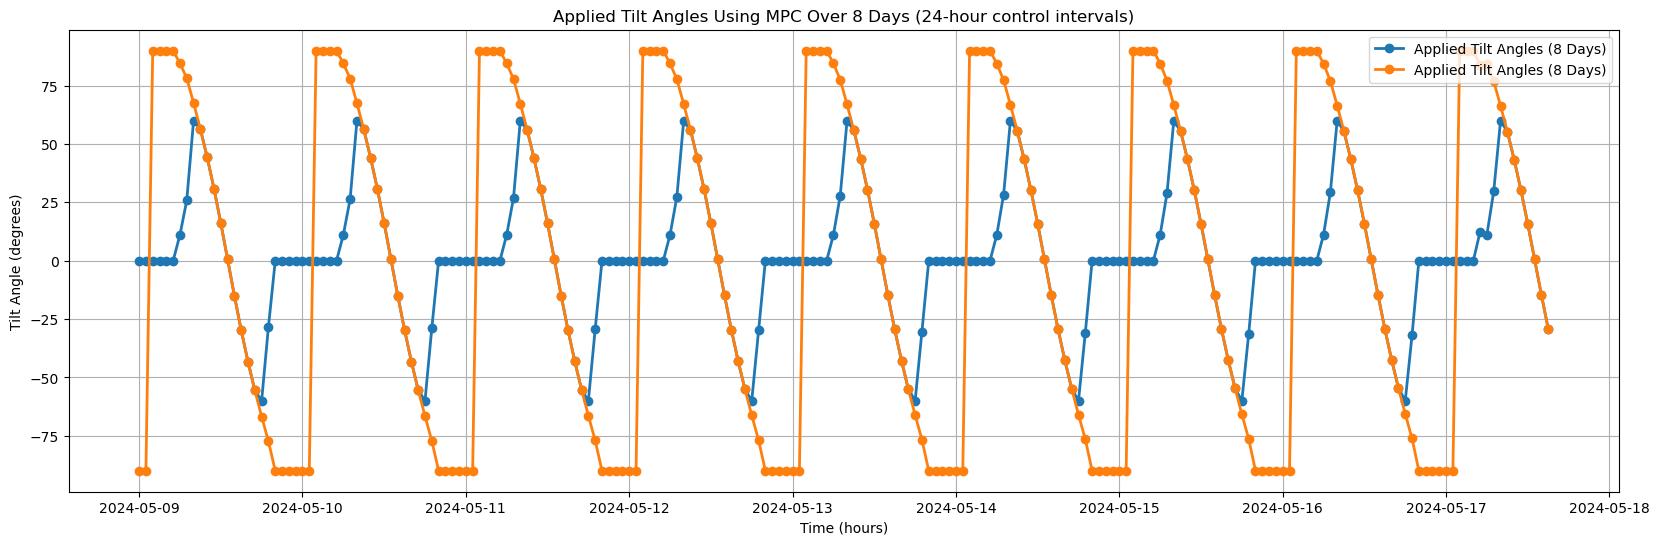

In [ ]:
# Plot the applied tilt angles
plt.figure(figsize=(20, 6))
plt.plot(hourly_timesteps[192:400], np.rad2deg(value(model.θ[:])[192:400]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(hourly_timesteps[192:400], np.rad2deg(optimal_angle[192:400]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (hours)")
plt.ylabel("Tilt Angle (degrees)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()

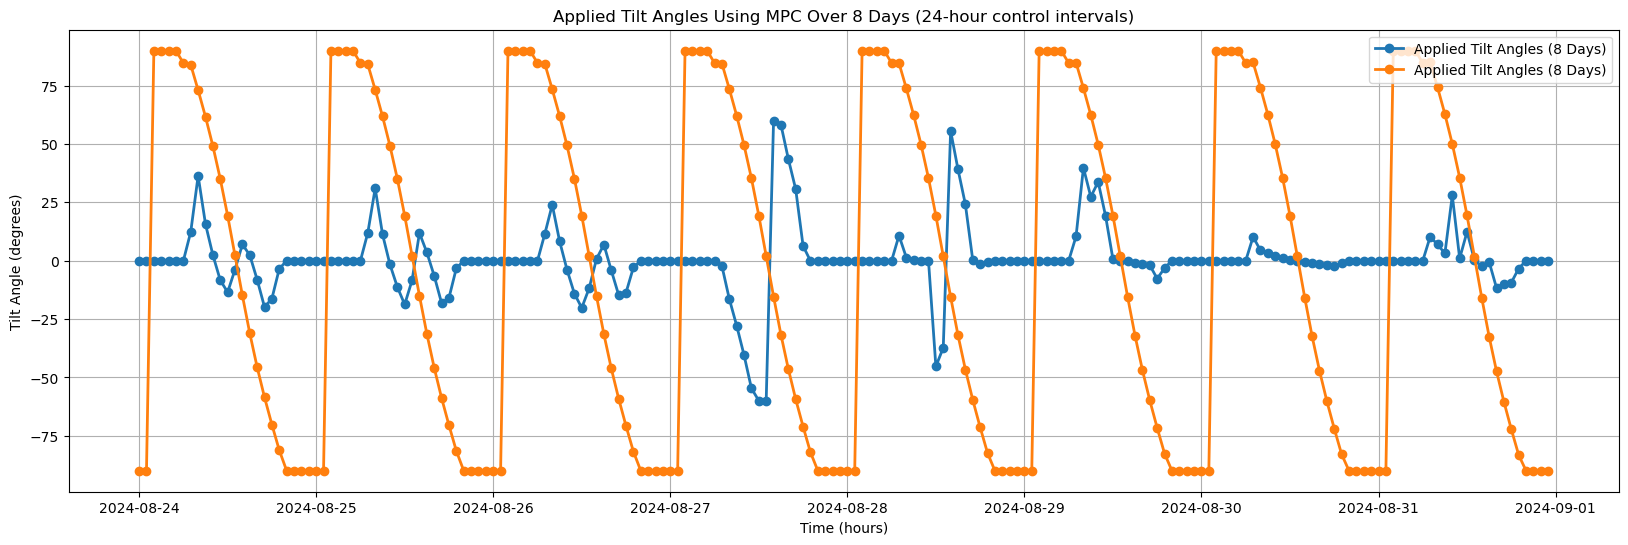

In [ ]:
# Plot the applied tilt angles
plt.figure(figsize=(20, 6))
plt.plot(hourly_timesteps[-192:], np.rad2deg(value(model.θ[:])[-192:]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(hourly_timesteps[-192:], np.rad2deg(optimal_angle[-192:]), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (hours)")
plt.ylabel("Tilt Angle (degrees)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()

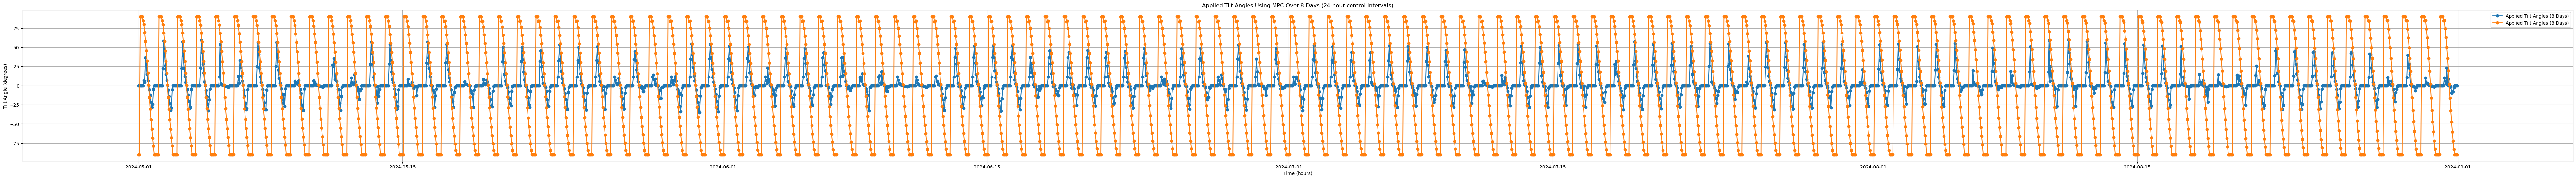

In [37]:
# Plot the applied tilt angles
plt.figure(figsize=(100, 6))
plt.plot(hourly_timesteps, np.rad2deg(value(model.θ[:])), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(hourly_timesteps, np.rad2deg(optimal_angle), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (hours)")
plt.ylabel("Tilt Angle (degrees)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()

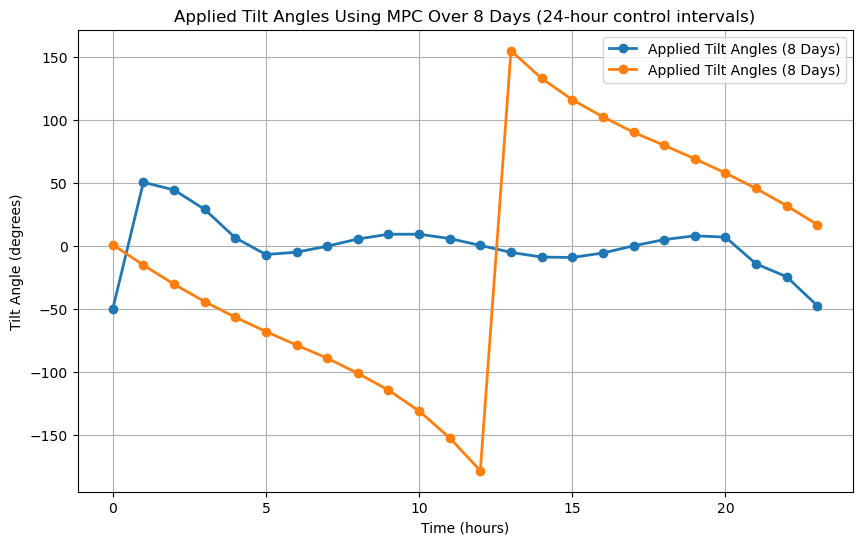

In [ ]:
# Plot the applied tilt angles
plt.figure(figsize=(10, 6))
plt.plot(range(len(np.rad2deg(value(model.θ[:])))), np.rad2deg(value(model.θ[:])), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")
plt.plot(range(len(np.rad2deg(value(model.θ[:])))), np.rad2deg(optimal_angle), label="Applied Tilt Angles (8 Days)", lw=2, marker="o")

plt.xlabel("Time (hours)")
plt.ylabel("Tilt Angle (degrees)")
plt.title("Applied Tilt Angles Using MPC Over 8 Days (24-hour control intervals)")
plt.grid(True)
plt.legend()
plt.show()
